# Exploratory Data Analysis - Preparing for one of the top performing models

In this notebook, an exploratory data analysis is performed on Give Me Some Credit's training set and preprocessing steps will be listed. These preprocessing steps will be the preparatory work for training a XGBoost model on the dataset, which is able to attain private and public scores of **0.86756** and **0.86104** respectively. The private and public scores are ranked top 100 and top 130 respectively (at the point of time of submitting this notebook).

More comprehensive README and Python scripts can be found at 

https://github.com/nicholaslaw/kaggle-credit-scoring

## Table of Contents

1. [Import Packages](#1)
2. [Import Data](#2)
3. [EDA](#3)
4. [Preprocessing Suggestions](#4)
5. [References](#5)

## Import Packages <a class="anchor" id="1"></a>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Import Data <a class="anchor" id="2"></a>

In [4]:
df = pd.read_csv("cs-training.csv")
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## EDA <a class="anchor" id="3"></a>

- Around 6% of samples defaulted
- MonthlyIncome and NumberOfDependents have 29731 (19.82%) and 3924 (2.61%) null values respectively
- We also notice that when NumberOfTimes90DaysLate has values above 17, there are 267 instances where the three columns NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse share the same values, specifically 96 and 98.
    - We can see that sharing the same values of 96 and 98 respectively is not logical since trivial calculations can reveal that being 30 days past due for 96 times for a single person within a timespan of 2 years is not possible.
- RevolvingUtilizationOfUnsecuredLines
    - Defined as ratio of the total amount of money owed to total credit limit
    - distribution of values is right-skewed, consider removing outliers
    - It is expected that as this value increases, the proportion of people defaulting should increase as well
    - However, we can see that as the minimum value of this column is set to 13, the proportion of defaulters is smaller than that belonging to the pool of clients with total amount of money owed not exceeding total credit limit.
    - Thus we should remove those samples with RevolvingUtilizationOfUnsecuredLines's value more than equal to 13
- age
    - There seems to be more younger people defaulting and the distribution seems fine on the whole
- NumberOfTimes90DaysLate
    - It is interesting to note that there are no one who is 90 or more days past due between 17 and 96 times.
- NumberOfTime60-89DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 60-89 days past due between 11 and 96 times.
- NumberOfTime30-59DaysPastDueNotWorse
    - It is interesting to note that there are no one who is 30-59 days past due between 13 and 96 times.
- DebtRatio
    - 2.5% of clients owe around 3490 or more times what they own
    - For the people who have monthly income in this 2.5%, only 185 people have values for their monthly incomes and the values are either 0 or 1.
    - There are 164 out of these 185 people who are of two different types, first with no monthly income and does not default and second with monthly income and does default.
- MonthlyIncome
    - Distribution of values is skewed, we can consider imputation with median.
    - We can also consider imputing with normally distributed values with its mean and standard deviation.
- Numberof Dependents
    - We can consider imputing with its mode, which is zero.

### Derive Balance of Classes

Proportion of People Who Defaulted: 0.06684


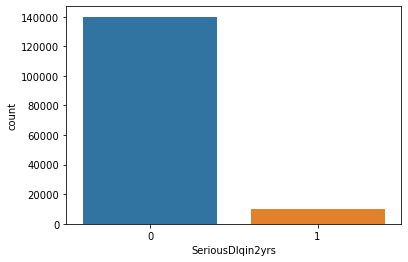

In [5]:
sns.countplot(x="SeriousDlqin2yrs", data=df)
print("Proportion of People Who Defaulted: {}".format(df["SeriousDlqin2yrs"].sum() / len(df)))

### Null Values and Proportions

In [6]:
null_val_sums = df.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df) })

,Column,Number of Null Values,Proportion
0,Unnamed: 0,0,0.000000
1,SeriousDlqin2yrs,0,0.000000
2,RevolvingUtilizationOfUnsecuredLines,0,0.000000
3,age,0,0.000000
4,NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
5,DebtRatio,0,0.000000
6,MonthlyIncome,29731,0.198207
7,NumberOfOpenCreditLinesAndLoans,0,0.000000
8,NumberOfTimes90DaysLate,0,0.000000
9,NumberRealEstateLoansOrLines,0,0.000000


### RevolvingUtilizationOfUnsecuredLines

In [7]:
df["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

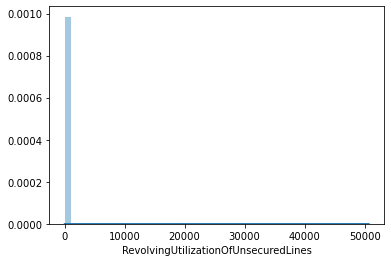

In [8]:
sns.distplot(df["RevolvingUtilizationOfUnsecuredLines"])

In [9]:
default_prop = []
for i in range(int(df["RevolvingUtilizationOfUnsecuredLines"].max())):
    temp_ = df.loc[df["RevolvingUtilizationOfUnsecuredLines"] >= i]
    default_prop.append([i, temp_["SeriousDlqin2yrs"].mean()])
default_prop

[[0, 0.06684],
 [1, 0.37177950868783705],
 [2, 0.14555256064690028],
 [3, 0.09931506849315068],
 [4, 0.08679245283018867],
 [5, 0.07874015748031496],
 [6, 0.07692307692307693],
 [7, 0.0778688524590164],
 [8, 0.07407407407407407],
 [9, 0.07053941908713693],
 [10, 0.07053941908713693],
 [11, 0.07053941908713693],
 [12, 0.06666666666666667],
 [13, 0.058823529411764705],
 [14, 0.058823529411764705],
 [15, 0.05531914893617021],
 [16, 0.05531914893617021],
 [17, 0.05531914893617021],
 [18, 0.05531914893617021],
 [19, 0.05555555555555555],
 [20, 0.05555555555555555],
 [21, 0.05555555555555555],
 [22, 0.05555555555555555],
 [23, 0.05555555555555555],
 [24, 0.05555555555555555],
 [25, 0.05555555555555555],
 [26, 0.05555555555555555],
 [27, 0.05555555555555555],
 [28, 0.05555555555555555],
 [29, 0.05555555555555555],
 [30, 0.05150214592274678],
 [31, 0.05150214592274678],
 [32, 0.05150214592274678],
 [33, 0.05150214592274678],
 [34, 0.05150214592274678],
 [35, 0.05150214592274678],
 [36, 0.05150

Text(0.5, 1.0, 'Proportion of Defaulters As Minimum RUUL Increases')

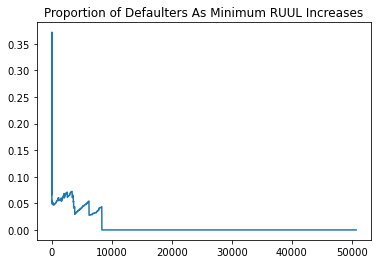

In [16]:
sns.lineplot(x=[i[0] for i in default_prop], y=[i[1] for i in default_prop])
plt.title("Proportion of Defaulters As Minimum RUUL Increases")

In [17]:
print("Proportion of Defaulters with Total Amount of Money Owed Not Exceeding Total Credit Limit: {}"\
     .format(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] <= 1)]["SeriousDlqin2yrs"].mean()))

Proportion of Defaulters with Total Amount of Money Owed Not Exceeding Total Credit Limit: 0.05991996127598361


In [18]:
print("Proportion of Defaulters with Total Amount of Money Owed Not Exceeding or Equal to 13 times of Total Credit Limit:\n{}"\
     .format(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] < 13)]["SeriousDlqin2yrs"].mean()))

Proportion of Defaulters with Total Amount of Money Owed Not Exceeding or Equal to 13 times of Total Credit Limit:
0.06685273968029273


### age

In [ ]:
df["age"].describe()

In [ ]:
sns.distplot(df["age"])

In [ ]:
sns.distplot(df.loc[df["SeriousDlqin2yrs"] == 0]["age"])

In [ ]:
sns.distplot(df.loc[df["SeriousDlqin2yrs"] == 1]["age"])

### Late Payment Columns

- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfTime30-59DaysPastDueNotWorse

In [ ]:
late_pay_cols = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]
df["NumberOfTimes90DaysLate"].value_counts().sort_index()

In [ ]:
df["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index()

In [ ]:
df["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index()

In [ ]:
df.loc[df["NumberOfTimes90DaysLate"] > 17][late_pay_cols].describe()

In [ ]:
distinct_triples_counts = dict()
for arr in df.loc[df["NumberOfTimes90DaysLate"] > 17][late_pay_cols].values:
    triple = ",".join(list(map(str, arr)))
    if triple not in distinct_triples_counts:
        distinct_triples_counts[triple] = 0
    else:
        distinct_triples_counts[triple] += 1
distinct_triples_counts

### DebtRatio

In [ ]:
df["DebtRatio"].describe()

In [ ]:
df["DebtRatio"].quantile(0.95)

In [ ]:
df.loc[df["DebtRatio"] > df["DebtRatio"].quantile(0.95)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

In [ ]:
len(df[(df["DebtRatio"] > df["DebtRatio"].quantile(0.95)) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])])

In [ ]:
df.loc[df["DebtRatio"] > df["DebtRatio"].quantile(0.95)]["MonthlyIncome"].value_counts()

In [ ]:
print("Number of people who owe around 2449 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(df.loc[(df["DebtRatio"] > df["DebtRatio"].quantile(0.95)) & (df["MonthlyIncome"] == df["SeriousDlqin2yrs"])])))

In [ ]:
df["DebtRatio"].quantile(0.975)

In [ ]:
df.loc[df["DebtRatio"] > df["DebtRatio"].quantile(0.975)][["DebtRatio", "MonthlyIncome", "SeriousDlqin2yrs"]].describe()

In [ ]:
len(df[(df["DebtRatio"] > df["DebtRatio"].quantile(0.975)) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])])

In [ ]:
df.loc[df["DebtRatio"] > df["DebtRatio"].quantile(0.975)]["MonthlyIncome"].value_counts()

In [ ]:
print("Number of people who owe around 3490 or more times what they own and have same values for MonthlyIncome and SeriousDlqin2yrs: {}"\
     .format(len(df.loc[(df["DebtRatio"] > df["DebtRatio"].quantile(0.975)) & (df["MonthlyIncome"] == df["SeriousDlqin2yrs"])])))

### MonthlyIncome

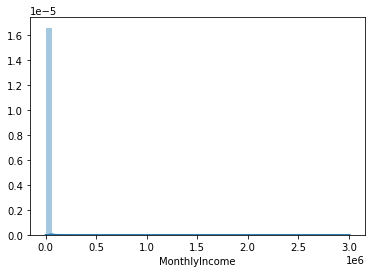

In [10]:
sns.distplot(df["MonthlyIncome"].dropna())

In [11]:
df["MonthlyIncome"].describe()

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

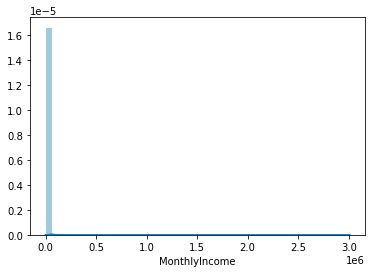

In [12]:
sns.distplot(df.loc[df["DebtRatio"] <= df["DebtRatio"].quantile(0.975)]["MonthlyIncome"].dropna())

### NumberOfOpenCreditLinesAndLoans

In [13]:
df["NumberOfOpenCreditLinesAndLoans"].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [14]:
df["NumberOfOpenCreditLinesAndLoans"].value_counts()

6     13614
7     13245
5     12931
8     12562
4     11609
9     11355
10     9624
3      9058
11     8321
12     7005
2      6666
13     5667
14     4546
1      4438
15     3645
16     3000
17     2370
0      1888
18     1874
19     1433
20     1169
21      864
22      685
23      533
24      422
25      337
26      239
27      194
28      150
29      114
30       88
31       74
32       52
33       47
34       35
35       27
36       18
38       13
40       10
39        9
45        8
43        8
42        8
37        7
48        6
41        4
54        4
49        4
46        3
52        3
51        2
56        2
57        2
50        2
47        2
44        2
53        1
58        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

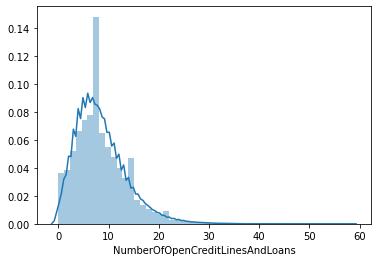

In [15]:
sns.distplot(df["NumberOfOpenCreditLinesAndLoans"])

### NumberRealEstateLoansOrLines

In [19]:
df["NumberRealEstateLoansOrLines"].describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [20]:
df["NumberRealEstateLoansOrLines"].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

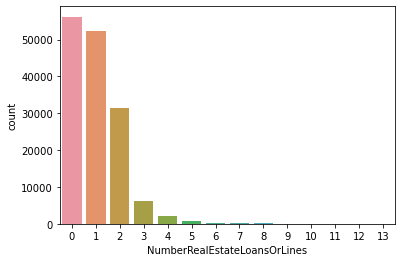

In [23]:
sns.countplot(x="NumberRealEstateLoansOrLines", data=df.loc[df["NumberRealEstateLoansOrLines"] <= 13])

In [22]:
df.loc[df["NumberRealEstateLoansOrLines"] > 13]["SeriousDlqin2yrs"].describe()

count    38.000000
mean      0.210526
std       0.413155
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

### NumberOfDependents

In [ ]:
df["NumberOfDependents"].describe()

In [ ]:
df["NumberOfDependents"].value_counts()

In [ ]:
df.loc[df["NumberOfDependents"] <= 10]["SeriousDlqin2yrs"].describe()

In [ ]:
sns.countplot(x="NumberOfDependents", data=df.loc[df["NumberOfDependents"] <= 10])

## Preprocessing Suggestions <a class="anchor" id="4"></a>

- Remove samples with values of DebtRatio above its 97.5 percentile
- Set 0 <= RevolvingUtilizationOfUnsecuredLines < 13
- Set NumberOfTimes90DaysLate <= 17
- Impute MonthlyIncome with its median, or with a normally distributed variable with MonthlyIncome's mean and standard deviation
- Impute NumberOfDependents with its mode

## References <a class="anchor" id="5"></a>

https://github.com/nicholaslaw/kaggle-credit-scoring